# Automated Slugging Detection using Machine Learning

#### By Deirdree A. Polak - github alias: dapolak
Imperial College London
MSc Applied Imperial Sciences and Engineering

August 2019

## Import Package

Load the slugdetection package, if this is used in a DataBricks Python noteboook, the following code will need to be run. Alternatively, the slugdetection package can also be attached directly to the cluster.

In [3]:
runtime=spark.conf.get("spark.databricks.clusterUsageTags.sparkVersion")
if "-ml-" not in runtime:
  dbutils.library.install("dbfs:/FileStore/jars/49037586_d162_4365_a6ba_9b25277b75c8/slugdetection-0.0.1-py3-none-any.whl") # FileStor location and name of package
  #dbutils.library.installPyPI("")
  dbutils.library.restartPython()

Import all the modules form the slugdetection package as such:

In [5]:
from slugdetection import *

And import all other relevant modules for the package

In [7]:
# General imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# Pyspark imports
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Scikit Learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Stats Models Time Series Analysis imports
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## Load Data
If this is run from DataBricks directly, the following code can be run. The tables need to be pre-loaded in the database

In [9]:
# From original well_wh_choke table in database, select the timestamp and wh_choke values
WH_choke = spark.table("well_wh_choke").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("WH_choke"),
  )
# From original well_dh_p table in database, select the timestamp and wh_choke values
DH_P = spark.table("well_dh_p").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("DH_P"),
  )
# From original well_wh_p table in database, select the timestamp and wh_choke values
WH_P = spark.table("well_wh_p").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("WH_P"),
  )
# From original well_dh_t table in database, select the timestamp and wh_choke values
DH_T = spark.table("well_dh_t").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("DH_T"),
  )
# From original well_wh_t table in database, select the timestamp and wh_choke values
WH_T = spark.table("well_wh_t").select(
  F.to_timestamp(F.col("ts"),format="dd-MMM-yy HH:mm").cast("timestamp").alias("ts"),
  F.col("value").cast("double").alias("WH_T"),
  )

Join the individual tables together using a full join on the timestamp

In [11]:
# Join the individual tables into one spark dataframe. 
data_spark = WH_P.join(DH_P, 'ts', how='full').join(DH_T, "ts", how='full').join(WH_T, "ts", how='full').join(WH_choke, "ts", how='full')

## Data Engineering

Before any analysis can take place, the data needs to be cleaned for missing values and out of bound values. The following selection walk you through the different methods available in the Data_Engineering module.

First the Data Engineering class needs to instantiated with the Spark data frame. The data fram can then be cropped on timestamps, and out of range values can be replace by the previous in range values using the data_range method.

In [13]:
well = Data_Engineering(data_spark) # A data instance is created. The data frame is now an pbject
well.timeframe(start="01-JAN-14 09:09") # Data can be clipped for time

well.set_thresholds("WH_P", 100, 5) # The thresholds values were automatically set for the well sampled, but they can be changed easily using the set_threshold method.
well.data_range() # The five streams of data WHP, DHP, WHT, DHT and WH choke are thresholded

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]

The following function cleans the choke data. this means it deletes any WH_choke values that are below 99%, meaning the well is closed or being choked.

In [15]:
well.clean_choke() # The data can be cleaned on the WH_choke. Either all data points with values less than a 99% opened choke are dropped, or when choke isn't constant/ is closed (=0%)

Some useful tools include showing the stats of the data frame, its size or resetting the data frame to its original data.

In [17]:
stats = well.stats() # Information regarding the table
display(stats)

summary,WH_P,DH_P,DH_T,WH_T,WH_choke
count,1799808,1799808,1799808,1799808,1799808
mean,12.388468734728137,103.59784177508847,87.77798975372254,77.5597412729762,99.56856167840415
stddev,3.6564891411930853,6.250788036025823,3.5420317510139534,3.0005720876323867,0.2534013478820294
min,0.0,0.0,0.0,-9.3017578125,99.00096520796305
max,103.52734375,123.43832953467616,88.11937713623047,99.9851579105714,100.828125


In [18]:
well.reset_well_df() # This commands allows to go back to the original non clipped df (only applies to Spark Dataframe)

Finally the data needs to be changed to a pandas dataframe for any future analysis. This is made easy with the df_toPandas method. Additionally the data can be plotted completely, or for selected time ranges.

In [20]:
pd_well = well.df_toPandas() # Convert data to a Pandas dataframe for further transformations

Converting Spark data frame to Pandas
Converted

In [21]:
well.pd_df = pd_well.copy()
plt.rc('axes', titlesize=30, labelsize=25)
plt.rcParams['figure.figsize'] = [40, 12]
plt.rc('axes', titlesize=30, labelsize=25)
plt.rcParams['legend.fontsize'] =  20
plt.rcParams['legend.handlelength']= 2

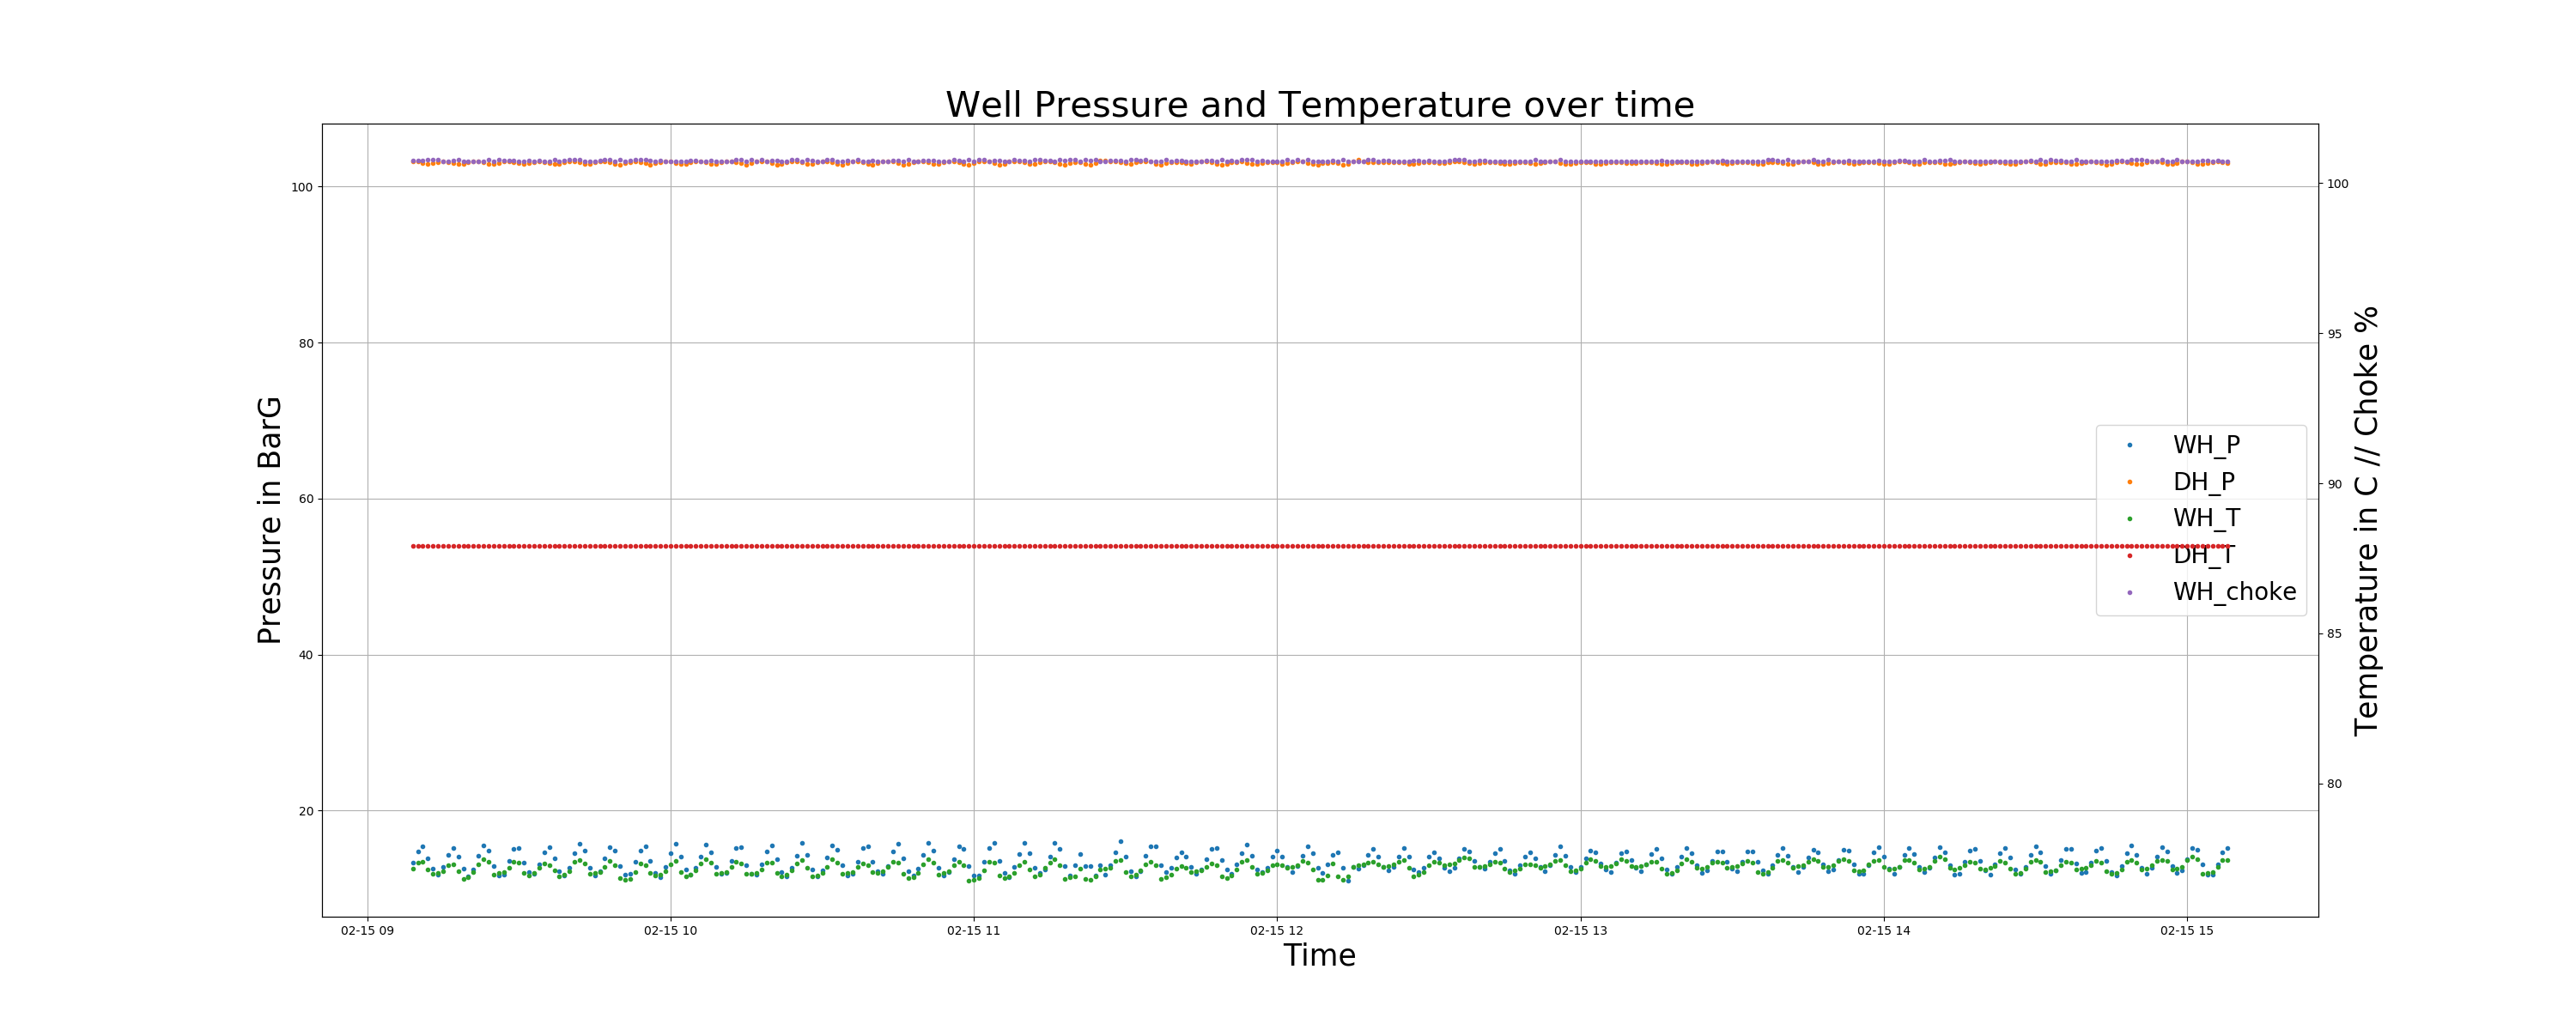

In [22]:
plot = well.plot(start="15-FEB-16 09:09", end="15-FEB-16 15:09") # Simple plot function. Data can be cropped again
display(plot)

The data shown above represents six hours of data. The flow presented is actually slugging flow, as can be seen fromm the high variance in WHP.


Below you can run the test for the package to ensure it i srunning correctly. Note that the tests require input data to instantiate the class, and therefore cannot be run as unittest.

In [24]:
from slugdetection import Test_Data_Engineering
test_object = Test_Data_Engineering()
test_object.test_create_class(data_spark)
test_object.test_reset_well_df(data_spark)
test_object.test_timeframe(data_spark)
test_object.test_set_thresholds(data_spark)
test_object.test_data_range(data_spark)
test_object.test_clean_choke(data_spark)
test_object.test_df_toPandas(data_spark)
test_object.test_standardise(data_spark)

## Slug Labelling

In this section, the slug labelling module is walked through. The slug labelling was created with the intent that similar flow patterns in windows of time would cluster together and therefore make the labelling of slug flow easier. The expected flows are: 

- Choked Flow (where WH choke is shut)
- Normal Flow (where variations in WHP are small)
- Slug Flow (where variations in WHP are high, and regular)
- Slug  after  Choke,  in  transition  (where  the  variations  in  WHP  are  high,  uneven,  and  the  choke  is changing)
- Slug formation, in transition (where the variations in WHP are increasing)



The Slug Labelling class is instantiated same as the Data_Engineering The standard transformations like the timeframe crops and data range need to be apploed before switching to the Pandas dataframe.

In [26]:
sl = Slug_Labelling(data_spark)
sl.timeframe(start="01-JAN-14 09:09")
sl.data_range()
sl.clean_choke() # No choke method is preferred in this case to keep the continuity in the data
df = sl.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

The Slug Labelling class follows a standard process, where the data needs to be transformed into feature vectors as specified by the user and then used in a KMeans classifier to cluster the similar flow types together.

In [28]:
sl.feature_vector(window_size = 20, step=10, standardise=False)

print("Number of feature vectors:", len(sl.feature_vec))

Number of feature vectors: 179979

In [29]:
sl.Kmean_classification(n_labels=5)

Cluster 0 contains 31.24 % of the data
Total of 56225 points
Cluster 1 contains 47.738 % of the data
Total of 85918 points
Cluster 2 contains 0.163 % of the data
Total of 294 points
Cluster 3 contains 0.124 % of the data
Total of 224 points
Cluster 4 contains 20.735 % of the data
Total of 37318 points

The clustering can then be viewed either by showing the repartition of the clusters as compared to 3 user chosen variables, or by plotting the feature vectors belonging to each class on top of eachother. With domain knowldge, it is then possible to identify the different flow types occuring in each cluster.

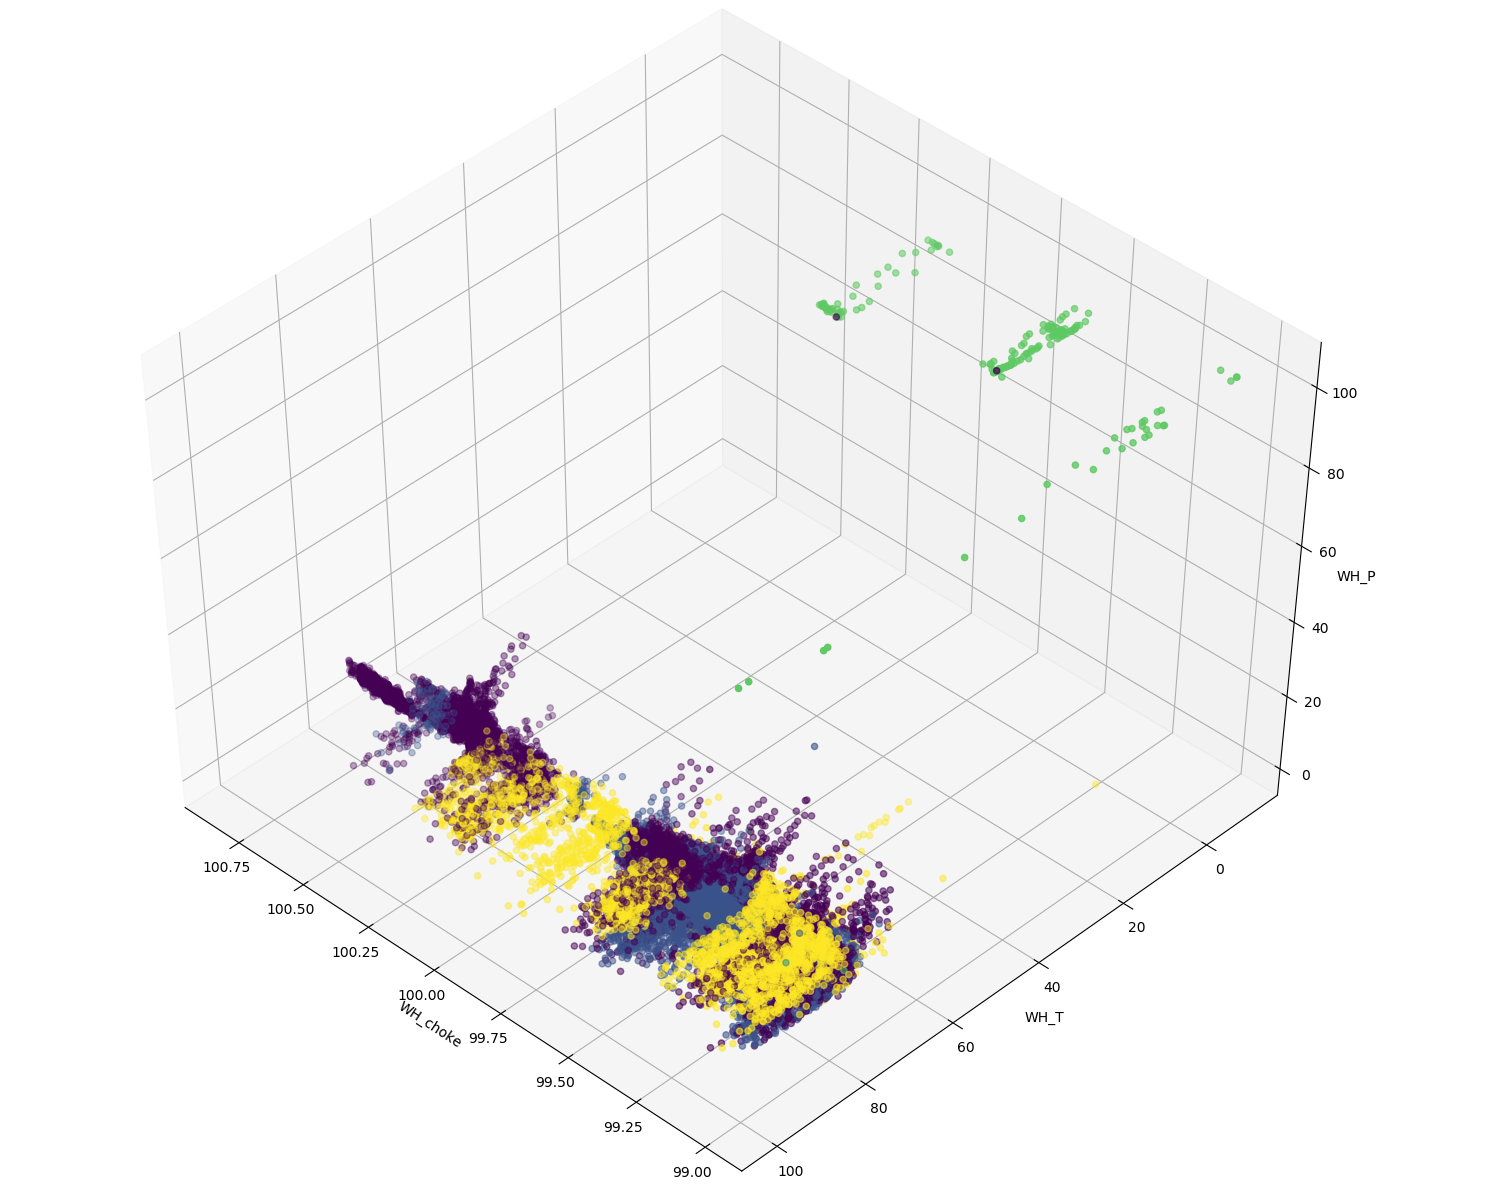

In [31]:
plt.rcParams['figure.figsize'] = [15, 12]
plot = sl.label_plot(["WH_choke", "WH_T", "WH_P"])
display(plot)

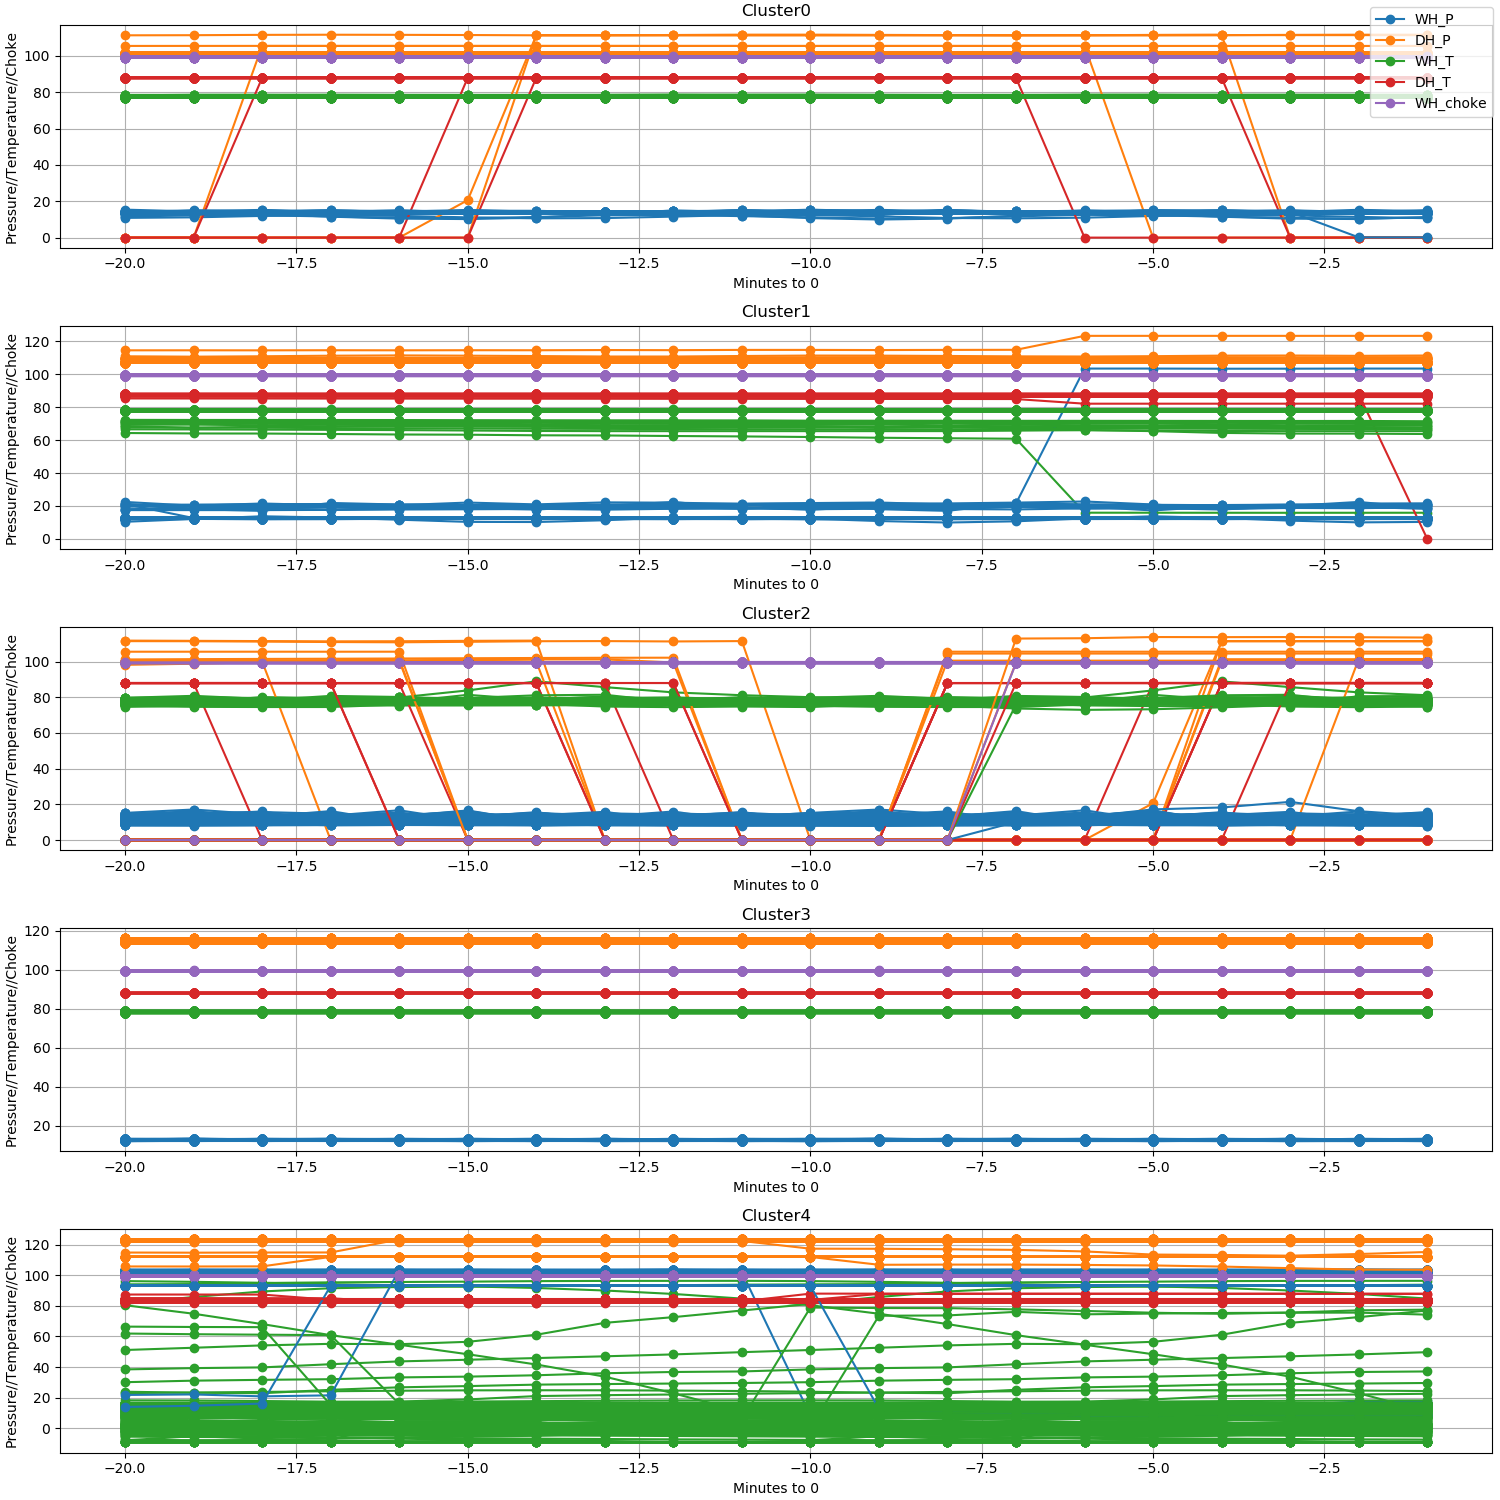

In [32]:
plot = sl.plot_feature_vectors(examples=2000) #plot window of times per label. Overlap same label windows
display(plot)

As can be sen the grouping is not conclusive. The same is performed on 40 minutes feature vectors.

In [34]:
sl.feature_vector(window_size = 40, step=20, standardise=False) # Standardisation turned off for purpose of seeing the patterns better in visualisation below
sl.Kmean_classification(n_labels=5)

Cluster 0 contains 30.007 % of the data
Total of 27003 points
Cluster 1 contains 0.164 % of the data
Total of 148 points
Cluster 2 contains 19.775 % of the data
Total of 17795 points
Cluster 3 contains 0.126 % of the data
Total of 113 points
Cluster 4 contains 49.928 % of the data
Total of 44930 points

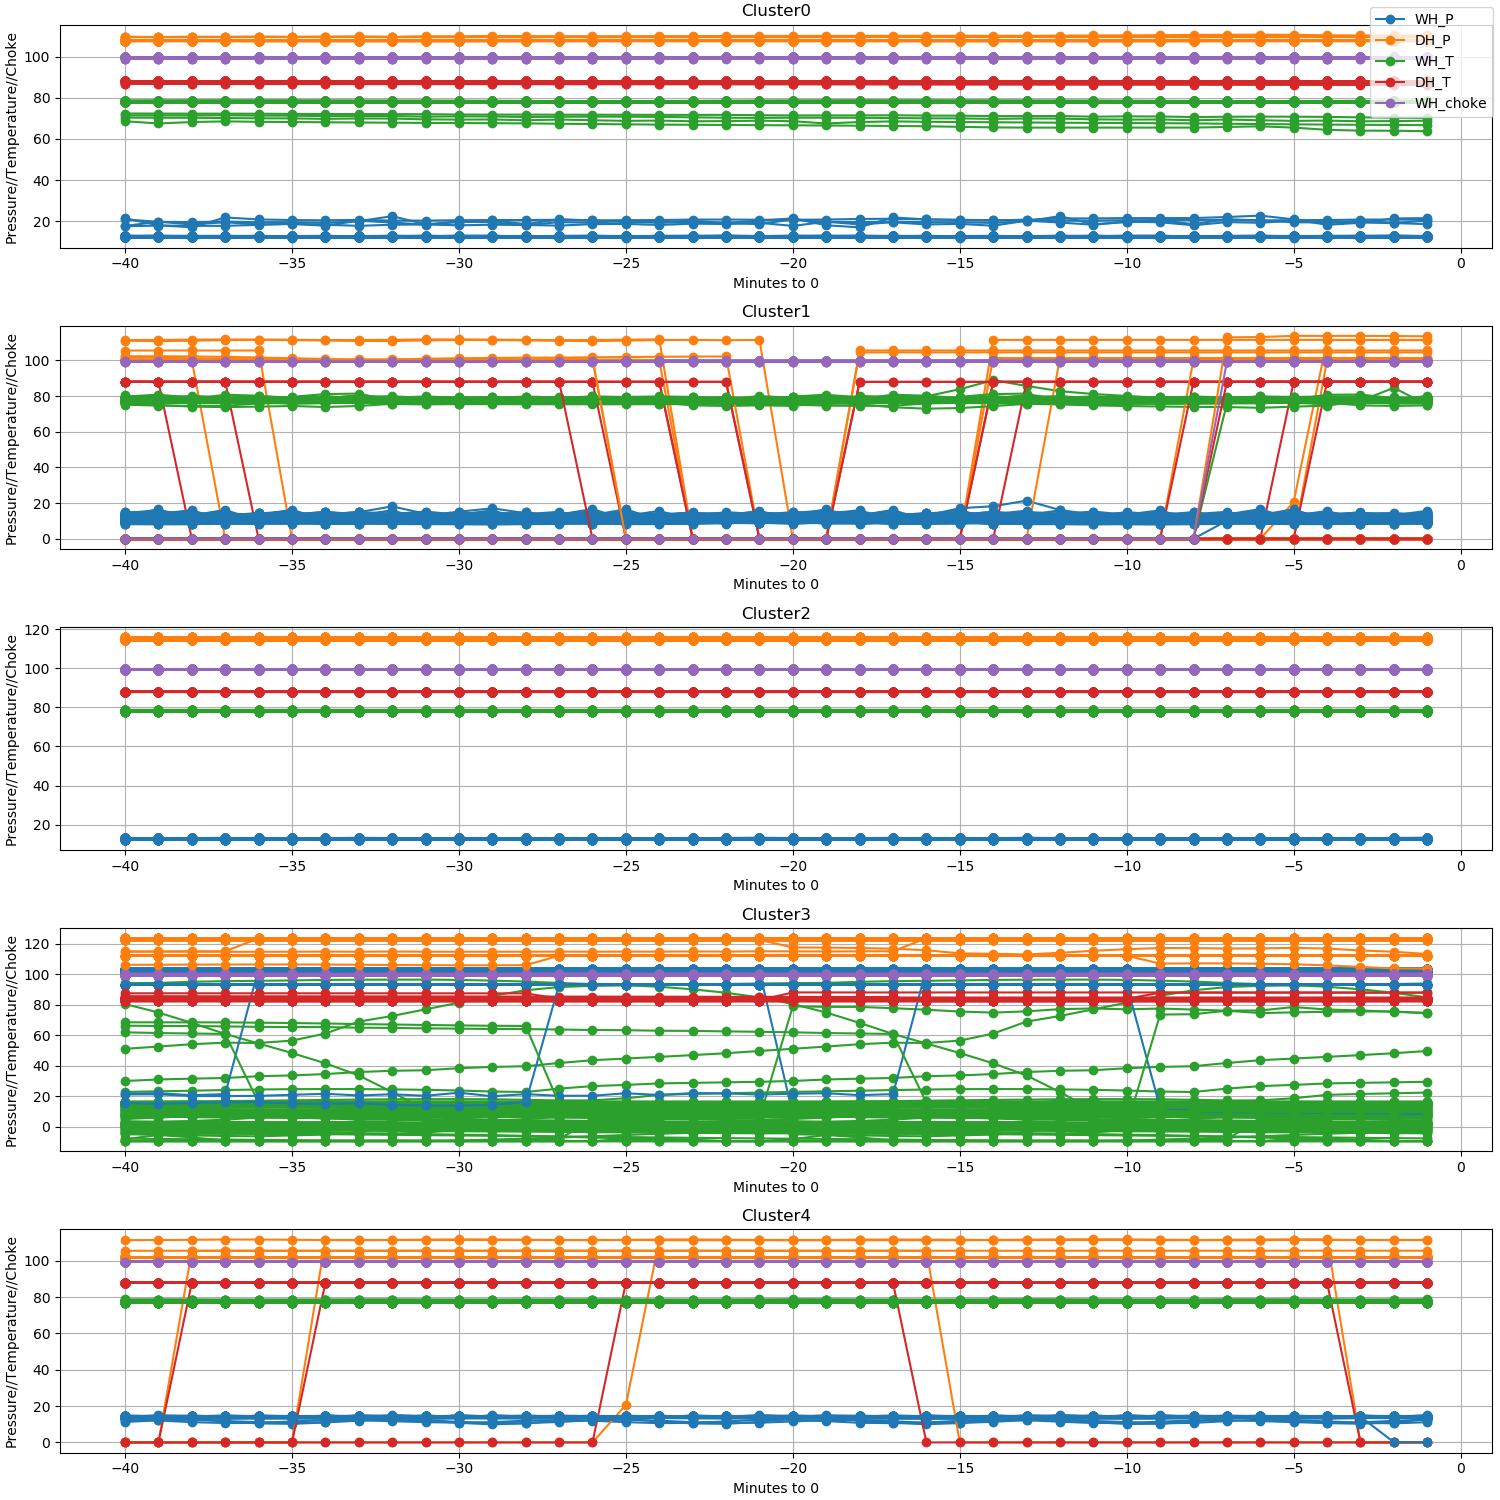

In [35]:
plot = sl.plot_feature_vectors(examples=500)
display(plot)

Here are the tests for the Slug_labelling class, to be used with the well's dataframe.

In [37]:
from slugdetection import Test_Slug_Labelling
test_obj = Test_Slug_Labelling()
test_obj.test_create_class(data_spark)
test_obj.test_feature_vector(data_spark)
test_obj.test_Kmean_classification(data_spark)
test_obj.test_get_labels(data_spark)
test_obj.test_label_plot(data_spark)
test_obj.test_unpack_feature_vector(data_spark)

## Flow Recognition

In this section the Flow Recognition module is introduced. The flow recognition class, which is a child class of the Data Engineering class, yielded low results overall. 

The Flow_Recognition class is instantiated and standard data engineering procedures are applied.

In [39]:
# Create the object and clean data at thresholds
fr = Flow_Recognition(data_spark)
fr.timeframe(start="01-JAN-14 09:09")
fr.data_range()
fr_df = fr.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

The data is labelled using five labels:
- "Slug", where the WHP gradient is larger than 3 BarG or user defined value
- "First Slug", where a labelled slug is the first slug to occur within a 30 minutes interval, or userdefined value
- "Pre-Slug", are the 60 data points prior to the first slug, or user defined value
- "Normal",  are  points  where  choke  is  constant  and  WHP  gradient  is  less  than  3  BarG  or  userdefined value
- "Ignore", are all other points and include the choked flows

This is performed by first labelling individual points using the label_slugs method, and then by creating the featire vectors which labels each vector by extrapolating from the labels of the individual points containd in the vector.

In [41]:
fr.label_slugs(pre_slug_period=30) # label all the individual slugs

fr.feature_vector(window_size=20, step=10) # create feature vectors

/databricks/python/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 self._setitem_with_indexer(indexer, value)

In [42]:
fr.feature_vec.columns # check that all the features were created

Out[7]: 
Index(['WH_P', 'DH_P', 'WH_T', 'DH_T', 'WH_choke', 'WH_P_1', 'DH_P_1',
 'WH_T_1', 'DH_T_1', 'WH_choke_1',
 ...
 'DH_P_19', 'WH_T_19', 'DH_T_19', 'WH_choke_19', 'WH_P_20', 'DH_P_20',
 'WH_T_20', 'DH_T_20', 'WH_choke_20', 'window_label'],
 dtype='object', length=106)

Once the data is labelled, the data can be split into a training and a testing set. The trainig data set is then used to train the Logisitics Regression or SVM model. The data split is performed automatically before the model is trained.

In [44]:
fr.LogReg_train(test_size=0.3)  #train model, and set test size for splitting the data

print("Number of training feature vectors:", len(fr.X_train))
print("Number of testing feature vectors:", len(fr.X_test))

Number of training feature vectors: 195994
Number of testing feature vectors: 83998

In [45]:
pred, proba, score, cm = fr.LogReg_pred()  #test model
print("Accuracy Score is:", round(score*100, 3), "%")

Accuracy Score is: 93.75 %

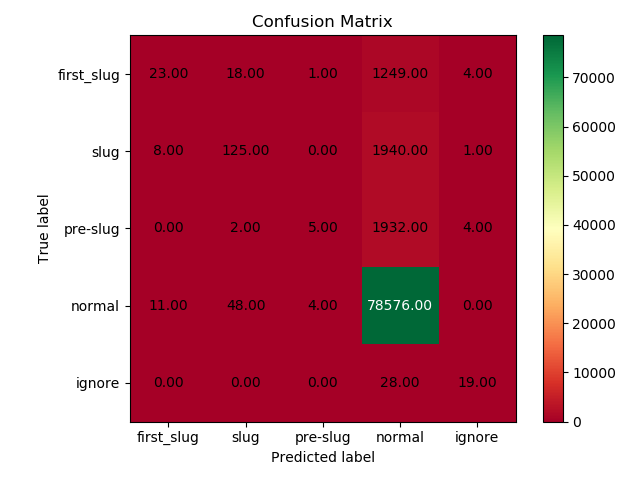

In [46]:
plot = confusion_mat(cm, labels=["first_slug", "slug", "pre-slug", "normal", "ignore"]) #plot confusion matrix for results. 
display(plot)

In [47]:
fr.SVM_train(krnl='rbf') # train model

pred, score, cm = fr.SVM_pred() # test model
print("Accuracy Score is:", round(score*100, 3), "%")

Accuracy Score is: 93.672 %

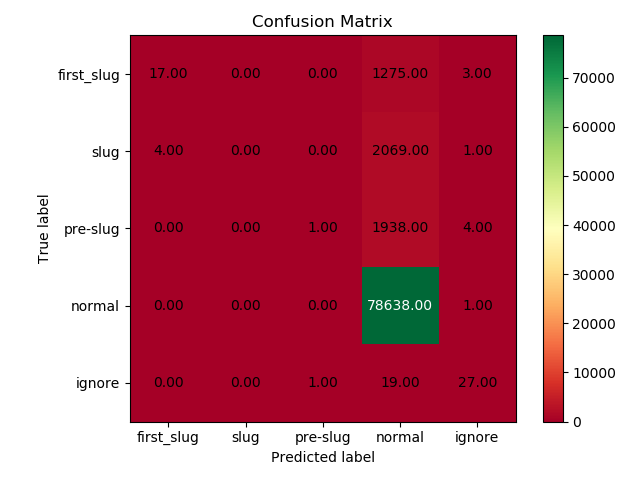

In [48]:
plot = confusion_mat(cm, labels=["first_slug", "slug", "pre-slug", "normal", "ignore"]) #plot confusion matrix for results. 
display(plot)

It can be seen that for both classiifcation models the results yeilded are relatively low. Whilst the overall accuracy sor are high (>90%), looking at each individual results within the confusion matrix it can be seen that it is actually because of the very high number of feature vector labelled 'normal' which is almost always correctly identified, but the other labels perform extremely poorly.


As usual, unit tests can be run for each method within the class:

In [50]:
from slugdetection import Test_Flow_Recognition
test_obj = Test_Flow_Recognition()
test_obj.test_create_class(data_spark)
test_obj.test_label_slugs(data_spark)
test_obj.test_window_label(data_spark)
test_obj.test_feature_vector(data_spark)
test_obj.test_split_data(data_spark)
test_obj.test_LogReg_train(data_spark)
test_obj.test_LogReg_pred(data_spark)
test_obj.test_SVM_train(data_spark)
test_obj.test_SVM_pred(data_spark)

## Slug Detection

In this section, the Data Engineering child class Slug_Detection is implemented. For this method, the choke must be cleaned and values below 99% for the WH_choke must be removed.

The hyperparameters were tuned and optimised using a Grid Search approach. The tuning can be seen in **IRP_HyperParameterTuning** notebook in the github repository.

In [52]:
 # Clean Data and convert
sd = Slug_Detection(data_spark)
sd.timeframe(start="01-JAN-14 09:09")
sd.data_range()
sd.clean_choke(method = "99")
pd_df = sd.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

Once the data frame has been cleaned from low WH_choke value and the pandas data frame has been created, the disccontinuouty in the data needs to be dealt with. All segments of continuous data lasting for less than 4 hours are discarded. The slug peaks are then identified, along with the first slug marking the start of the slug flow. The data is cut into short data frame of 240 points (equivalent to four hours worth of data), and given a True or false label depending on whether that time interval immediately leads to a slug flow or not. Finally feature vectors are created from the shortened data frames.

In [54]:
# All the data formatting has been regrouped in one function, and any argument can be passed in as kwargs
sd.data_prep(max_clean_count = 500, standardise=True)

In [55]:
# Otherwise, the data preparation can be performed by calling the functions one by one 

sd.sub_data() # split dataframe into smaller continous dataframes
first_idx, slug_idx = sd.label_slugs() # get index of the first slugs and slugs for each sub data frame

# format data into size_list (default 300) long dataframes, with label list
sd.format_data(first_idx, max_clean_count = 500)

# create data feature vectors
sd.feature_vector(standardise=True)

The class allows to plot where the slug flows are happening, by showing the slug peaks in example data a.d the first slugs.

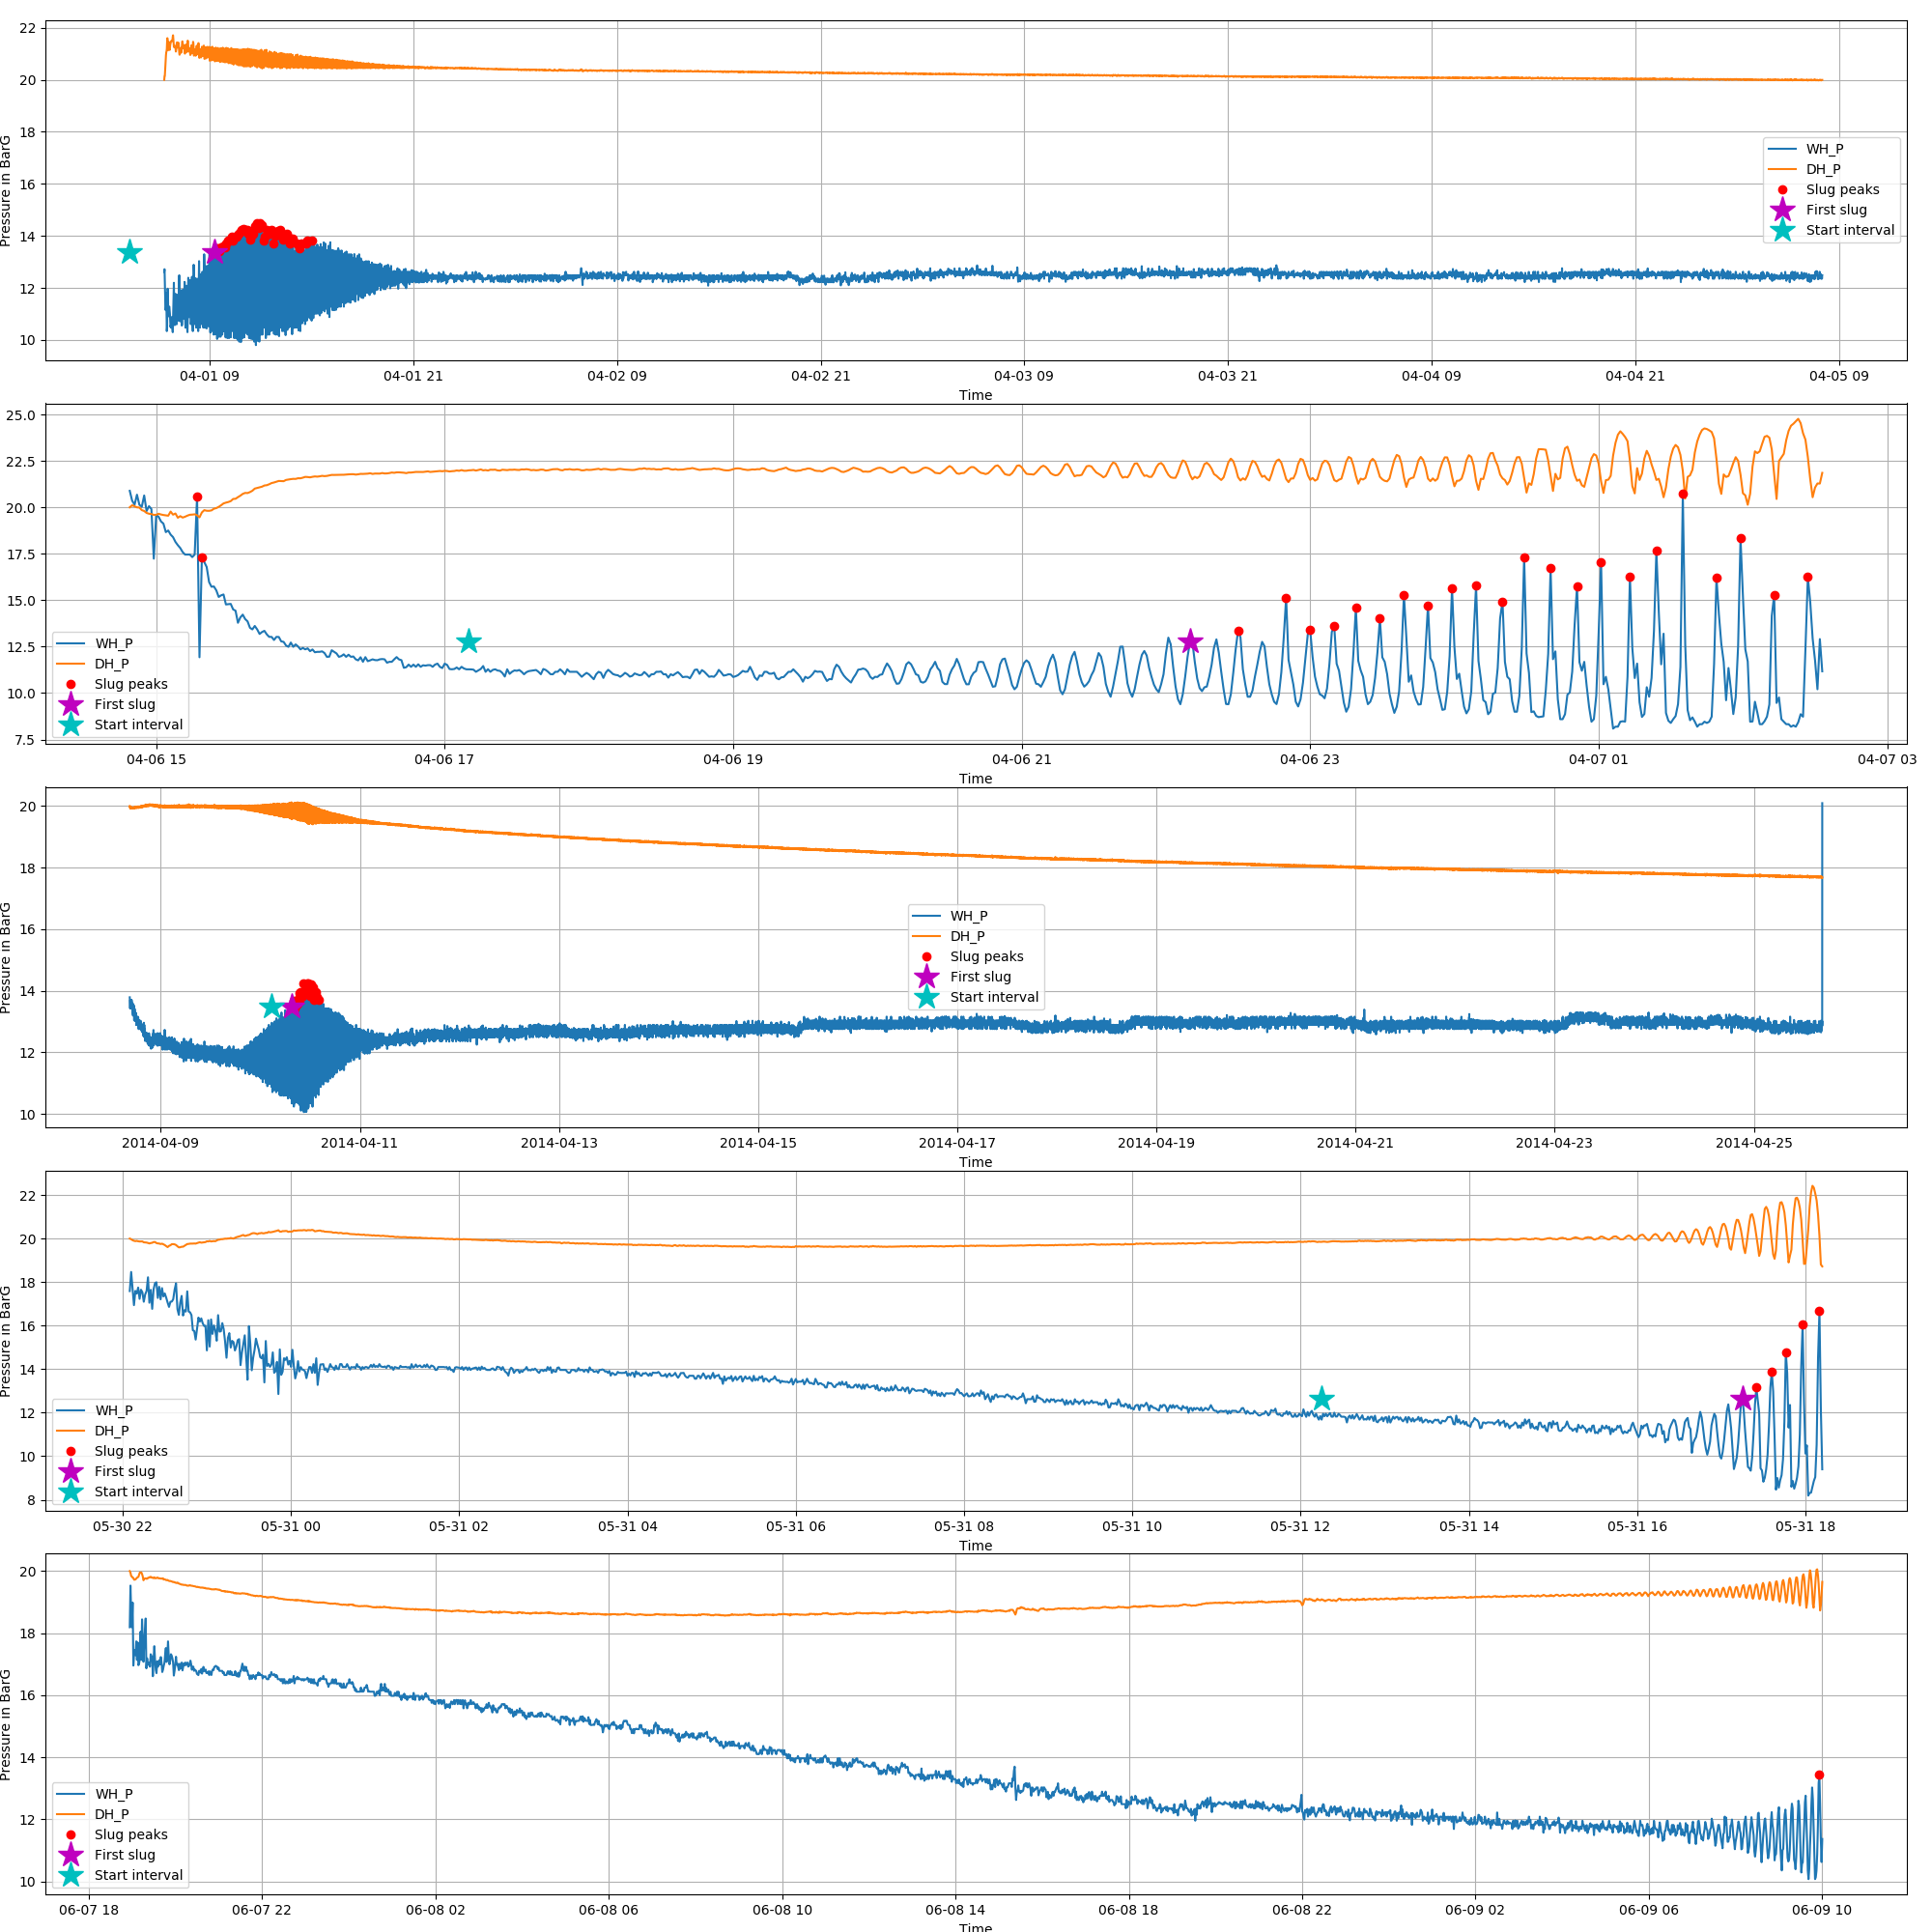

In [57]:
# view the raw continuous sub data frames and where slugs have been labelled
plot = sd.plot_raw_slugs(variables=["WH_P", "DH_P"], scaled=True, n_examples = 5, first_sample = 15)
display(plot)

The first slugs and slug as defined by the data labelling algorithm can clearly be seen above. Each figure is of different length, as it represents intervals of time the well wasn't choke, and is therefore entitrly dependant of the production. Note that a sluf flow ends when slug control is applied, like closing the choke or applying gas lift in the well.

Below are the same sized intervals. On the left are examples of intervals leading to a slug, whereas on the right are example of intervals not leading to a slug.

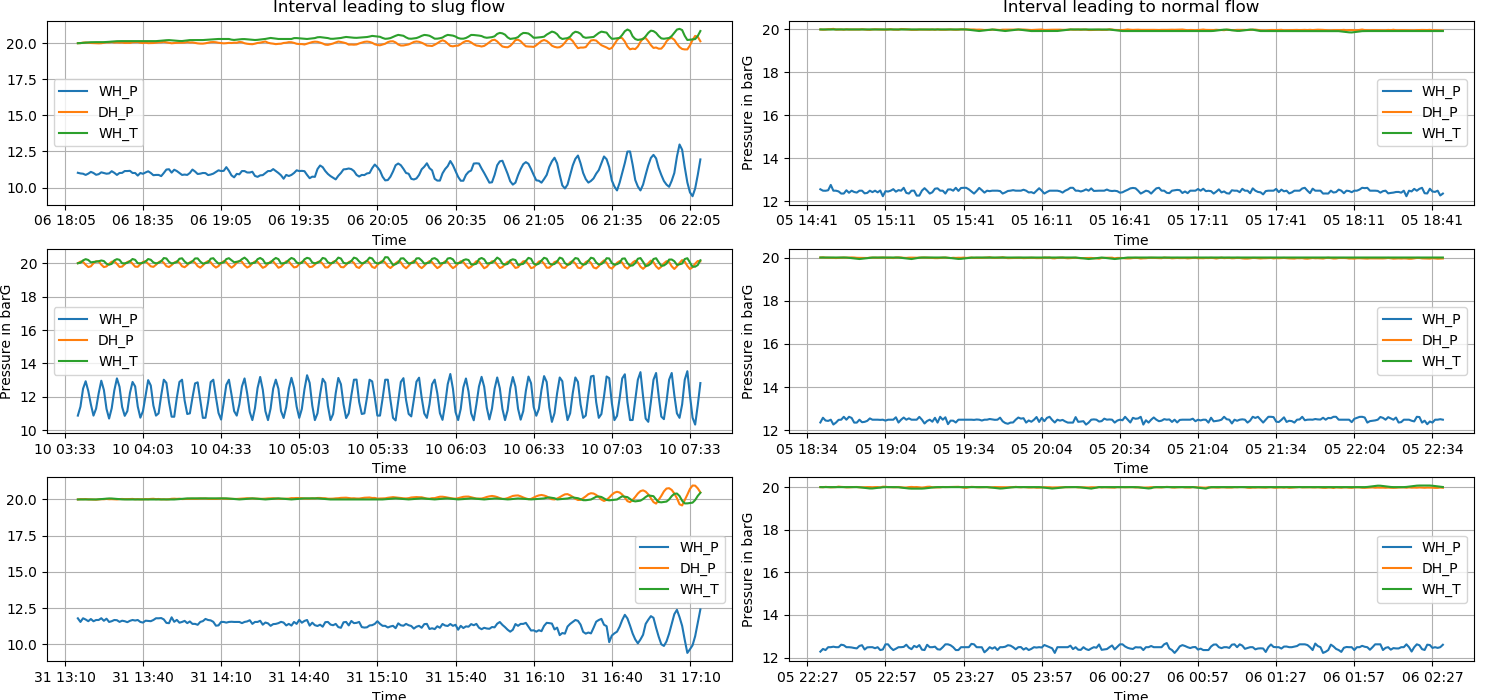

In [59]:
# You can view examples of the data being classified
plot = sd.plot_X(scaled=True, variables = ["WH_P", "DH_P", "WH_T"], start = 250) # The scaled variable means all the data will be scaled to WHP, the start allows to look at different intervals in the list.
display(plot)

The classification of the intervals takes place either by using Random Forest Classifier or by using Logistics Regressiom. It works similarly as the Flow Recognition methods.

In [61]:
# Train a Random Forest and extract the predictions feature importance
pred_f = sd.RF_train(test_size=0.3, bootstrap = True, max_depth = None, n_estimators=15) 

print("The number of training feature vectors is:", len(sd.X_train), " of which slug intervals:", int(sd.y_train.sum()))
print("The number of testing feature vectors is:", len(sd.X_test), " of which slug intervals:", int(sd.y_test.sum()))

The number of training feature vectors is: 486 of which slug intervals: 97
The number of testing feature vectors is: 209 of which slug intervals: 42

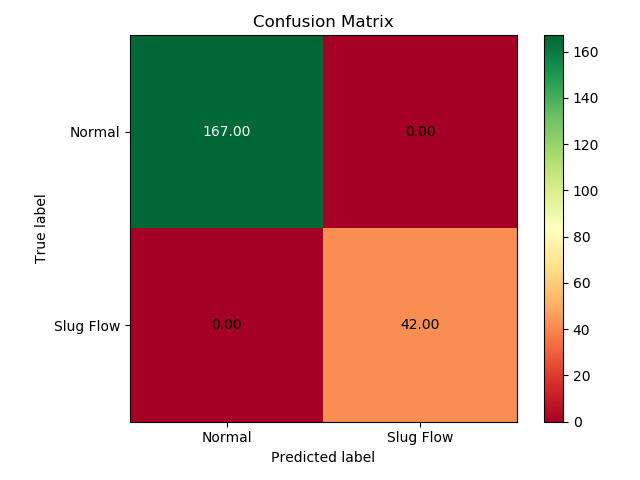

In [62]:
# Predict the label for the testing set. Additionall, X_test can be updated to any new data that needs to be classified.
rf_pred, rf_score, rf_cm = sd.RF_predict(true_label = True) # affirm that the true labels for testing are now

plot = confusion_mat(rf_cm, ["Normal", "Slug Flow"]) # plot confusion matrix
display(plot)

In [63]:
print("The accuracy score for the Random Forest model is", round(rf_score*100, 3), "%")

The accuracy score for the Random Forest model is 100.0 %

In [64]:
top_features = sd.feature_selection(pred_f, top_n=75) # from the perdiction feature importance list, extract the top 15 features
print(top_features)

['std_DH_P_4', 'std_WH_T_3', 'std_WH_P_1', 'std_DH_P_1', 'std_WH_T_2', 'mean_DH_P_1', 'mean_DH_P_2', 'mean_DH_P_3', 'std_DH_P_0', 'std_DH_T_2', 'std_WH_T_4', 'std_WH_P_3', 'mean_WH_P_2', 'mean_WH_P_1', 'num_mean_WH_T_sign_decr', 'mean_DH_P_4', 'std_WH_P_4', 'std_DH_P_3', 'mean_WH_T_2', 'mean_DH_P_0', 'diff_std_DH_P_3_4', 'mean_WH_P_3', 'diff_std_DH_T_2_3', 'diff_mean_DH_P_0_1', 'diff_mean_signif_DH_P_1_2', 'std_DH_T_4', 'diff_mean_signif_DH_P_2_3', 'std_WH_P_0', 'diff_mean_signif_DH_P_0_1', 'mean_DH_T_0', 'diff_std_DH_T_3_4', 'diff_std_DH_T_0_1', 'diff_std_signif_DH_P_0_1', 'diff_std_DH_P_0_1', 'diff_std_WH_P_2_3', 'diff_std_signif_WH_P_1_2', 'std_DH_T_0', 'diff_mean_signif_WH_T_1_2', 'mean_DH_T_1', 'mean_WH_T_0', 'diff_std_DH_P_1_2', 'std_DH_T_1', 'num_std_DH_P_sign_decr', 'diff_mean_WH_T_2_3', 'diff_std_WH_P_0_1', 'num_std_WH_P_sign_decr', 'diff_std_signif_WH_T_3_4', 'mean_WH_T_4', 'diff_std_trend_DH_P_2_3', 'diff_mean_DH_P_3_4', 'diff_mean_DH_T_2_3', 'num_mean_DH_P_sign_decr', 'diff_std_WH_P_3_4', 'diff_mean_WH_P_3_4', 'diff_mean_WH_T_1_2', 'mean_WH_P_0', 'std_WH_T_0', 'mean_WH_T_1', 'std_WH_T_1', 'std_WH_P_2', 'std_DH_P_2', 'mean_DH_T_2', 'mean_WH_T_3', 'mean_DH_T_3', 'std_DH_T_3', 'mean_WH_P_4', 'mean_DH_T_4', 'diff_mean_WH_P_0_1', 'diff_mean_trend_WH_P_0_1', 'diff_std_trend_WH_P_0_1', 'diff_mean_signif_WH_P_0_1', 'diff_std_signif_WH_P_0_1', 'diff_mean_trend_DH_P_0_1', 'diff_std_trend_DH_P_0_1', 'diff_mean_WH_T_0_1']

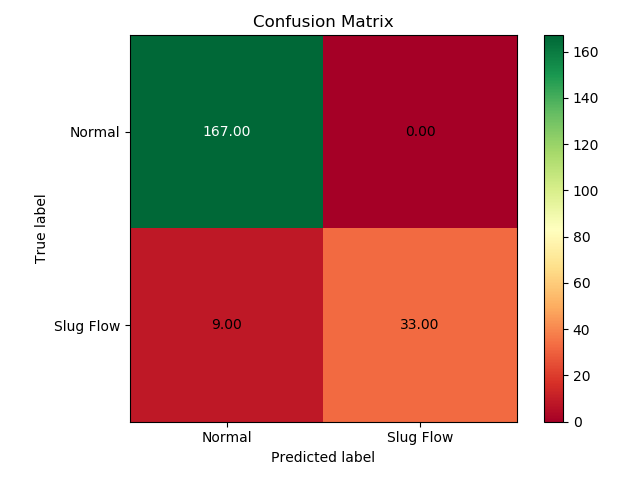

In [65]:
sd.LogReg_train(top_features, test_size=0.3, C=1.0, max_iter=50) # Train the Logistics Regression model, only using the top 15 features

# Predict the label for the testing set. Additionall, X_test can be updated to any new data that needs to be classified.
log_pred, log_proba, log_score, log_cm = sd.LogReg_pred(true_label = True) # affirm that the true labels for testing are now                                                                                                   

plot = confusion_mat(log_cm, ["Normal", "Slug Flow"]) # plot confusion matrix
display(plot)

In [66]:
print("The accuracy score for the Logistics model is", round(log_score*100, 3), "%")

The accuracy score for the Logistics model is 95.694 %

It can be seen that the Sug Detection is highly accurate. The results are explained in more details in the report.

There are unit test available for the Slug_Detection class:

In [68]:
from slugdetection import Test_Slug_Detection
test_obj = Test_Slug_Detection()
test_obj.test_create_class(data_spark)
test_obj.test_jump(data_spark)
test_obj.test_clean_short_sub(data_spark)
test_obj.test_sub_data(data_spark)
test_obj.test_slug_check(data_spark)
test_obj.test_label_slugs(data_spark)
test_obj.test_format_data(data_spark)
test_obj.test_feature_vector(data_spark)
test_obj.test_data_prep(data_spark)
test_obj.test_split_data(data_spark)
test_obj.test_RF_train(data_spark)
test_obj.test_feature_selection(data_spark)
test_obj.test_RF_predict(data_spark)
test_obj.test_LogReg_train(data_spark)
test_obj.test_LogReg_pred(data_spark)

## Slug Forecasting
Finally, the last module of the slugdetection package is the Slug Forecasting module. It enables users to forecast slug flow. It is the only class in the slugdetection peckage that is not inherited from the Data_Engineering class.

First the slug data has to be acquired from the original Spark data set. This is done by selecting a interval of at least 240 minutes from the data set.

In [70]:
# Acquire padnas dataframe fro Data Enfineering module
whp = Data_Engineering(data_spark) 
whp.timeframe(start="01-JAN-16 09:09", end="30-NOV-18 09:09") #start="01-JAN-16 09:09", end="30-NOV-18 09:09"
whp.data_range()
whp.features= ["WH_P"] # override
WHP_ = whp.df_toPandas()

WH_P treshold is [0, 100]
DH_P treshold is [90, 150]
DH_T treshold is [75, 95]
WH_T treshold is [0, 100]
WH_choke treshold is [-1000, 10000]
Converting Spark data frame to Pandas
Converted

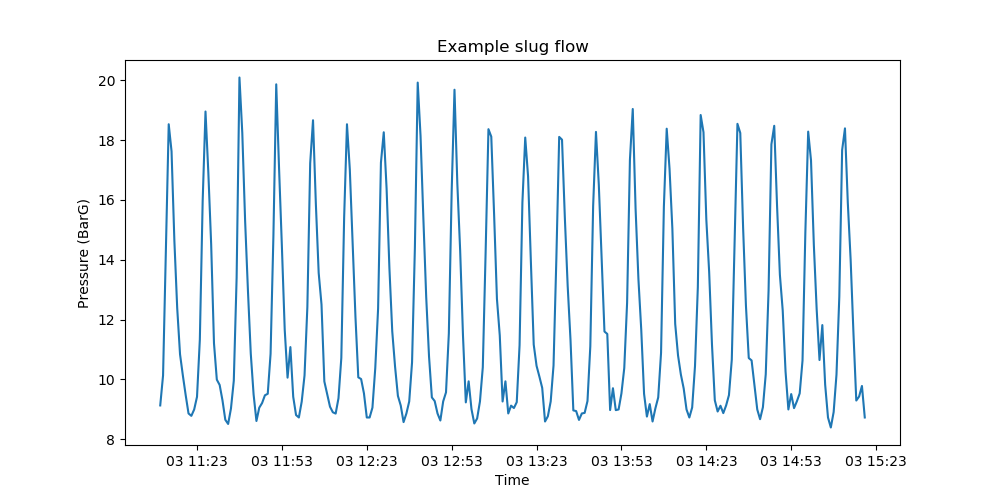

In [71]:
# Check sluf flow behaviour
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(WHP_[3000:3250]['ts'], WHP_[3000:3250]['WH_P'], 'C0-')
ax.set_title("Example slug flow")
ax.set_xlabel("Time")
ax.set_ylabel("Pressure (BarG)")
display(f)

In [72]:
WHP = WHP_[3000:3250].copy() # Clean data frame
WHP_notstation = WHP_[8000:10000].copy() # Non slug flow, for testing purposes.

The pandas data is then used to instantiate the Slug Forecasting class. Once the data is proven to be stationary and the parameters are approximated from the differencing required the ACF and the PACF the ARIMA model can be fitted.

In [74]:
sf = Slug_Forecasting(WHP.copy()) # Instantiate Slug_Foreactsing class with pandas dataframe
sf.stationarity_check(diff=0) # Check data is stationary. It should be if it is a a slug flow. Differencing can be applied if required.

ADF Statistic: -4.192408
p-value: 0.000679
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573

In [75]:
sf.split_data(train_size = 180, predict_size = 60) # Split data into training and prediction set

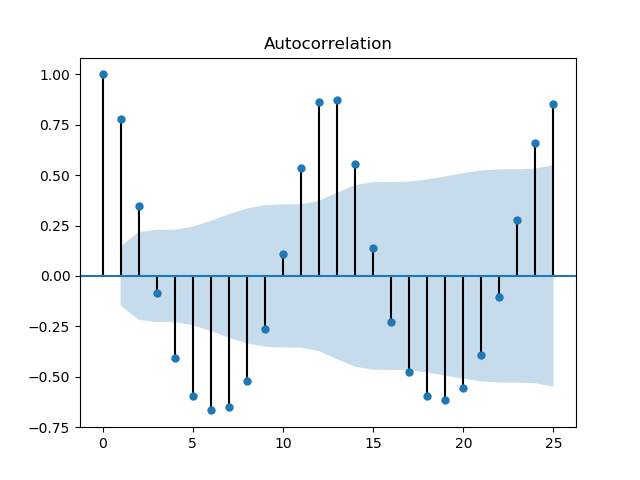

In [76]:
plot = sf.autocorrelation_plot() # Get Auto Correlation figure
display(plot)

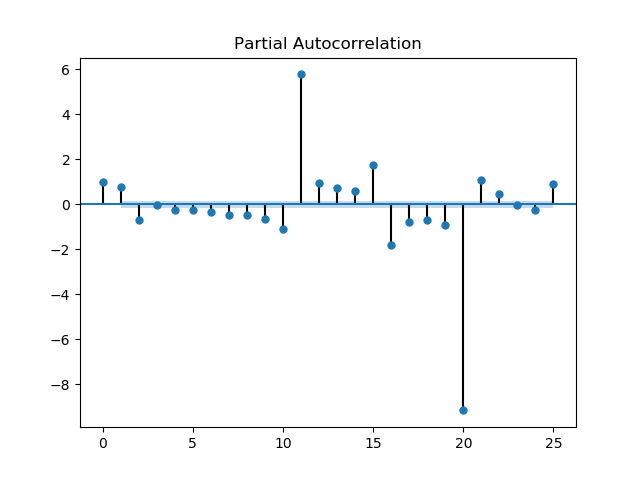

In [77]:
plot = sf.partial_autocorrelation_plot() # get Partial Auto Correlation Figure
display(plot)

The ARIMA model is fitted by using the three parametrs. The parameters can be tuned by looking at the erro infographics and the error metrics as shown below.

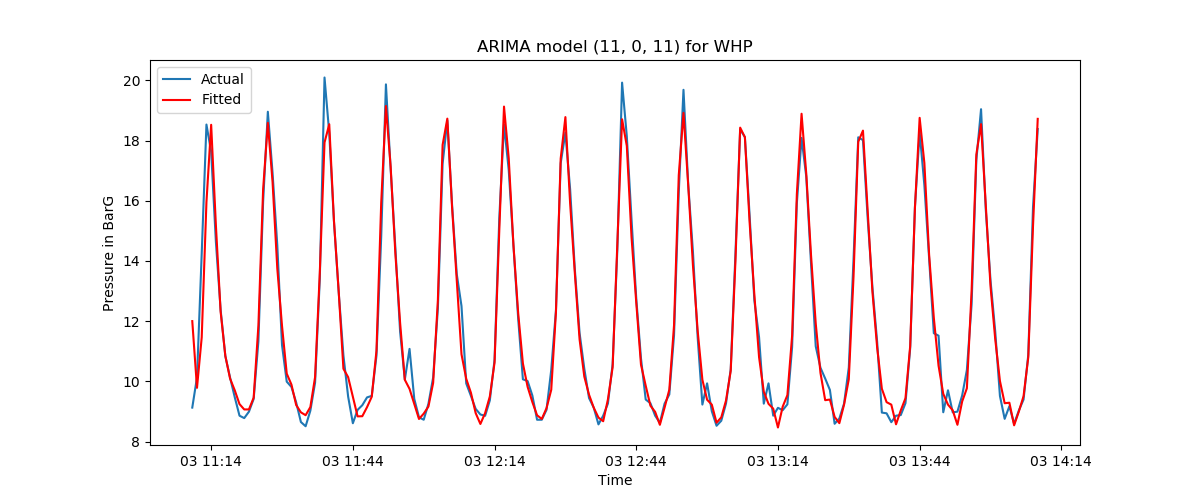

In [79]:
plot = sf.ARIMA_model(11, 0, 11) # Fit ARIMA model and display fit 
display(plot)

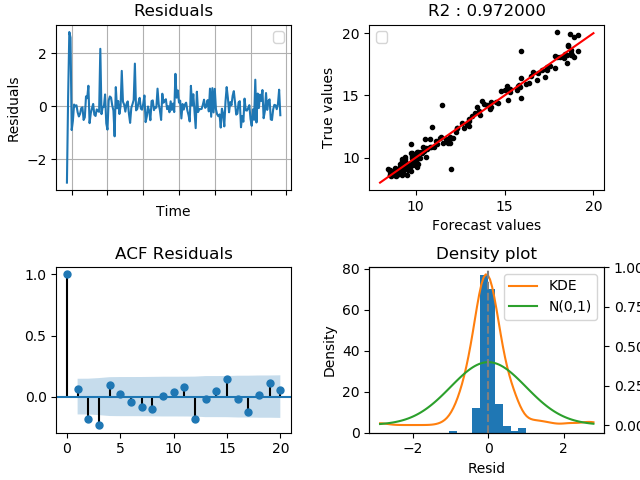

In [80]:
plot = sf.error_metrics_plot(error="fit") # Show error infographics
display(plot)

In [81]:
sf.error_metrics(error="fit") # Show error metrics

Mean Absolute Percentage Error: -0.131
Mean Squared Error: 0.321000
Root Mean Squared Error: 0.566000
R2 Determination: 0.972000
Out[64]: (-0.131, 0.321, 0.566, 0.972)

Once the fit is satisfactory, the flow can be forecasted. there is technically no limits to  how far the forecast can be, especially if the slug flow is repetitive. The forecast values can be inspected for errors using the same error infographic sand same error metrics as for the fit.

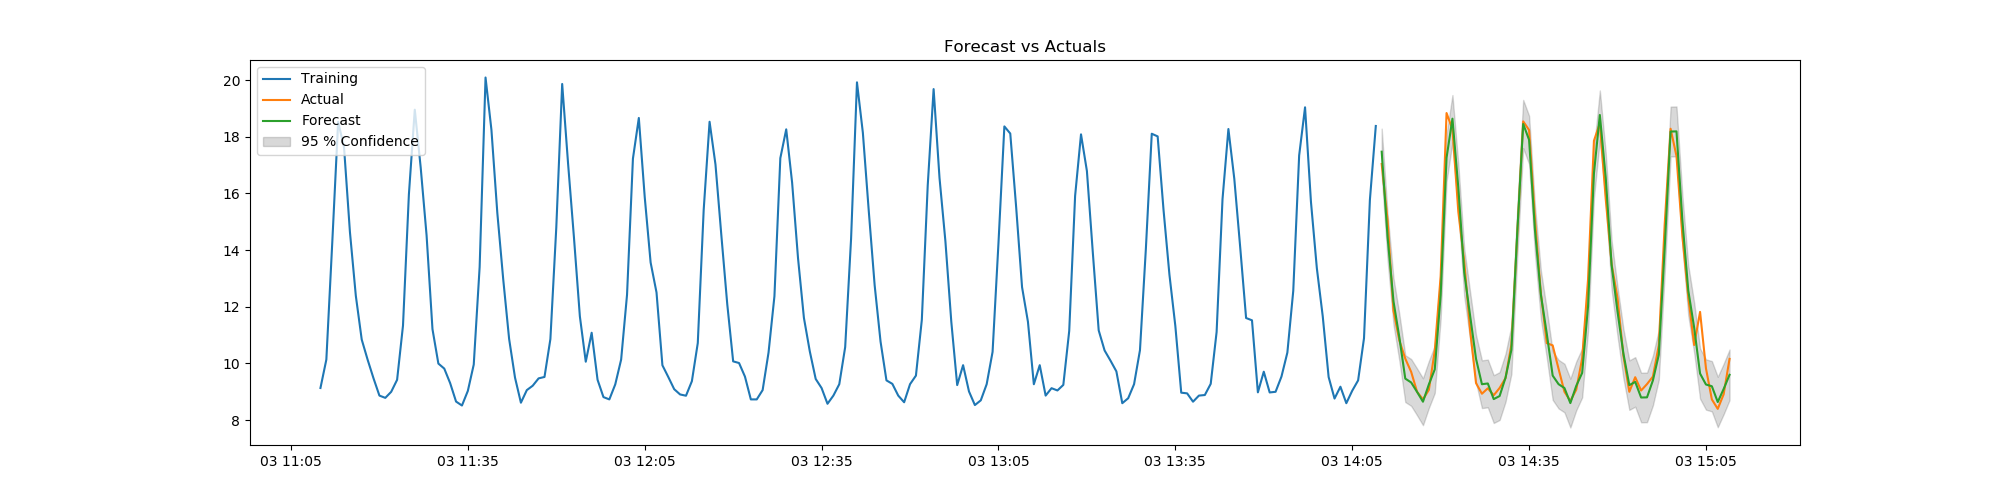

In [83]:
plot = sf.ARIMA_pred(pred_time=60) # Forecast slug flow
display(plot)

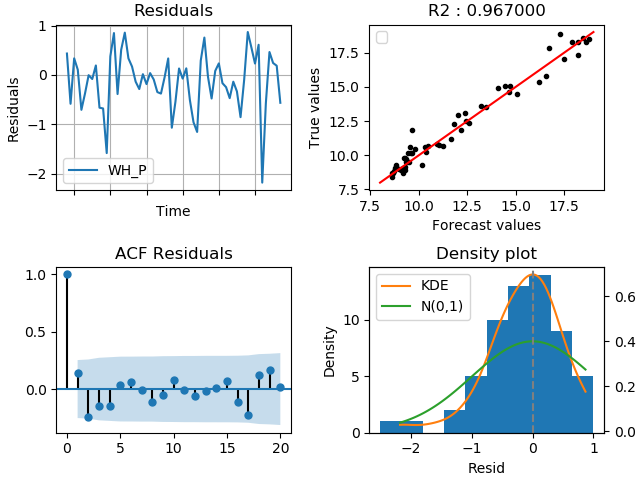

In [84]:
plot = sf.error_metrics_plot(error="pred") # Show error infographics for prediction
display(plot)

In [85]:
sf.error_metrics(error="pred") # Show error metrics for prediction

Mean Absolute Percentage Error: -1.014
Mean Squared Error: 0.344000
Root Mean Squared Error: 0.587000
R2 Determination: 0.967000
Out[67]: (-1.014, 0.344, 0.587, 0.967)

Again tests are available.

In [87]:
from slugdetection import Test_Slug_Forecasting
test_obj = Test_Slug_Forecasting()
test_obj.test_create_class(WHP)
test_obj.test_stationarity_check(WHP, WHP_notstation)
test_obj.test_split_data(WHP)
test_obj.test_ARIMA_model(WHP)
test_obj.test_error_metrics(WHP)
test_obj.test_ARIMA_pred(WHP)